## pyKO Test 12 Gravity
Al impactor on Al

### WARNING: Only works with tabular EOS and initializing one isothermal layer. Gravity needs more development.

pyKO documentation: https://impactswiki.github.io/pyko

Set the path to pyko and your fortran compiler in import-modules.py file

Sarah T. Stewart<br>
June 27, 2023<br>

In [1]:
# import the same set of modules for each test run provided with pyKO
%run import-modules

Platform:  Darwin Kernel Version 22.5.0: Thu Jun  8 22:21:34 PDT 2023; root:xnu-8796.121.3~7/RELEASE_ARM64_T8112
python version:  3.11.4
matplotlib version:  3.7.1
hvplot version:  0.8.4
numpy version:  1.25.0
pandas version:  2.0.2
pickle version:  4.0
yaml version:  6.0
pint version:  0.22
pyko version:  v0.6-release-2023-06-27

/usr/local/bin/gfortran

GNU Fortran (GCC) 12.1.0
Copyright (C) 2022 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.




In [2]:
# useful cell for project development
# if you make changes to pyko; you can use the reload function to avoid restarting the kernel
# can also set an autoreload for a fixed interval in time

from importlib import reload #import function "reload"
if 0:
    reload(pyko)
    import pyko
    from pyko import OutputClass as OutputClass
    from pyko import DebugClass as DebugClass
    from pyko import RunClass as RunClass


## Check input file

In [3]:
# start with your initial guess of the EOS initial state 
# load and print the configuration file without running the simulation
# 
filein = './test12/test12-gravity.yml'
# initialize the run class variable by loading the configuration file
# this loads the requires EOS tables, so you can inquire about initial states
run = RunClass(fin=filein)
# print the run class state; this will print in code units
run.checkinput()



pyKO v0.6-release-2023-06-27 run parameters
   All outputs are in code units 
   Input file: ./test12/test12-gravity.yml 
   Output file: ./test12/pyko-test12-gravity-Al-bin.dat 
   Number of materials: 2 
   Number of nodes in each material: [100  50] 
   Length of each material: [2000000. 1000000.] 
   Initial left edge of each material: [-2000000.   100000.] 
   Boundary conditions: ['FIXED', 'FREE']
   Material EOS:     ['SES', 'SES'] 
   Geometry:         PLA 
   Gravity:          -9.800000000000001e-10 
   Void pressure:    1e-09 
   Time step factor: 6 
   Stop time:        5000000.0

mat1 Von Mises parameters: 
   Shear modulus [Mbar]: 0.26 
   Yield stress [Mbar]: 0.0020700000000000002

mat1 Fracture parameters: 
   Fracture pressure: 1000000000.0000001 
   Fracture maximum distension (rhomin/rhoref): 0.8

Class SESAME: Aluminum 
   eos_table module version v1.1.4 
   table path: ../eos/aneos-Al-demo/ 
   file names: NEW-SESAME-STD.TXT NEW-SESAME-EXT.TXT 
   initial state: 
 

In [4]:
# query the SESAME table for the correct pressure and sp. internal energy
# given an initial density and temperature
p,u,cs = run.ieos[0].onepuc(2.7,298)
print(p,u,cs)
# p and u are in code units: Mbar and eu/g
print('\n****************')
print('For specified rho and T combination, the table EOS pressure and internal energy are = ',p, u)
# use pint to help you convert code units internal energy to mks
ureg.define('eu = 1.0E12 ergs') 
utmp = Q_(u,'eu/g') # creates a variable utmp that has pint units information
print('internal energy in code units: ',utmp) # prints the value and units
print('internal energy in mks units: ',utmp.to('J/kg')) # prints the value and units
ptmp = Q_(p,'Mbar') # creates a variable ptmp that has pint units information
print('pressure in code units: ',ptmp) # prints the value and units
print('pressure in mks units: ',ptmp.to('Pa')) # prints the value and units
cstmp = Q_(cs,'cm/microsecond')
print('bulk sound speed in code units: ',cstmp) # prints the value and units
print('bulk sound speed in mks units: ',cstmp.to('m/s')) # prints the value and units

2.3113752999999998e-06 0.0015514308799999996 0.518892471

****************
For specified rho and T combination, the table EOS pressure and internal energy are =  2.3113752999999998e-06 0.0015514308799999996
internal energy in code units:  0.0015514308799999996 eu / gram
internal energy in mks units:  155143.08799999996 joule / kilogram
pressure in code units:  2.3113752999999998e-06 megabar
pressure in mks units:  231137.52999999997 pascal
bulk sound speed in code units:  0.518892471 centimeter / microsecond
bulk sound speed in mks units:  5188.92471 meter / second


### Run python KO


In [5]:
%time pyko.run(fin=filein,userdtstart=0.001,verbose=True)


pyKO v0.6-release-2023-06-27 run parameters
   All outputs are in code units 
   Input file: ./test12/test12-gravity.yml 
   Output file: ./test12/pyko-test12-gravity-Al-bin.dat 
   Number of materials: 2 
   Number of nodes in each material: [100  50] 
   Length of each material: [2000000. 1000000.] 
   Initial left edge of each material: [-2000000.   100000.] 
   Boundary conditions: ['FIXED', 'FREE']
   Material EOS:     ['SES', 'SES'] 
   Geometry:         PLA 
   Gravity:          -9.800000000000001e-10 
   Void pressure:    1e-09 
   Time step factor: 6 
   Stop time:        5000000.0

mat1 Von Mises parameters: 
   Shear modulus [Mbar]: 0.26 
   Yield stress [Mbar]: 0.0020700000000000002

mat1 Fracture parameters: 
   Fracture pressure: 1000000000.0000001 
   Fracture maximum distension (rhomin/rhoref): 0.8

Class SESAME: Aluminum 
   eos_table module version v1.1.4 
   table path: ../eos/aneos-Al-demo/ 
   file names: NEW-SESAME-STD.TXT NEW-SESAME-EXT.TXT 
   initial state: 
 


## Load python KO results

In [6]:
# pyko output filename is in the input file
pykofileout = run.outputfilename
# initialize a class object to hold the output data
pko = [] # this variable will hold a plain (no units) pandas datafram for plotting
pkodata = OutputClass() # pandas + pint dataframe to read the pickled output data
#
# function to convert the stored pandas structure with pint units to a normal panda file
# hvplot tools do not work with a panda+pint file
# this also lets the user select a subset of variables to read into this notebook
def pyko_to_normal_panda(pkodata):
    df = pd.DataFrame({
            "j"    : pkodata.j.magnitude,
            "stepn" : pkodata.stepn.magnitude,
            "time" : pkodata.time.magnitude,
            "mat" : pkodata.mat.magnitude,
            "pos" : pkodata.pos.magnitude,
            "rho0" : pkodata.rho0.magnitude,
            "rho" : pkodata.rho.magnitude,
            "up" : pkodata.up.magnitude,
            "ie" : pkodata.ie.magnitude,
            "pres" : pkodata.pres.magnitude,
            "mass" : pkodata.mass.magnitude,
            "temp" : pkodata.temp.magnitude,
            "sigmar" : pkodata.sigmar.magnitude,
            "sigmao" : pkodata.sigmao.magnitude,
            "etot" : pkodata.etot.magnitude,
            "dtminj" : pkodata.dtminj.magnitude,
            })
    return df
#
# loop through all the pickle dumps to read in the simulation data
# concat onto a pandas dataframe that stores the variables vs. time
with open(pykofileout,"rb") as f:
    pkodata = pickle.load(f) # keeps units
    if 1:
        # print units
        print('pyKO output file units are the same as the input file units:')
        print('   Time        ',pkodata.time.units)
        print('   Position    ',pkodata.pos.units)
        print('   Density     ',pkodata.rho.units)
        print('   Part. vel.  ',pkodata.up.units)
        print('   Int. energy ',pkodata.ie.units)
        print('   Mass        ',pkodata.mass.units)
        print('   Temperature ',pkodata.temp.units)
        print('   Pressure    ',pkodata.pres.units)
        print('   Stress      ',pkodata.sigmar.units)
    pko = pyko_to_normal_panda(pkodata)
    while True:
        try:
            pkodata = pickle.load(f) # keeps units but only one snapshot at a time
            pko = pd.concat([pko,pyko_to_normal_panda(pkodata)],ignore_index=True) # strips units for plotting
        except:
            break

# convert to same units as fKO for plot comparisons
# from binary in mks
pko['ie']     *= 1.E-11*pko['rho0']    # J/kg * kg/m3 -> 100 GJ/m3 = eu/cm3
pko.rename(columns={"ie": "iev0"},inplace=True)
pko['etot']   *= 1.E-8    # J/kg 10e7 erg/1000 g -> erg/g *1.e-12 -> eu/g
print('iev0 and etot converted to eu/g')
pko['pos']    *= 1.0E2    # m->cm
pko['pres']   *= 1.E-9    # Pa -> GPa
pko['sigmar'] *= 1.E-9    # Pa -> GPa
pko['sigmao'] *= 1.E-9    # Pa -> GPa
pko['rho']    *= 1.E-3    # kg/m3 -> g/cm3
pko['rho0']   *= 1.E-3    # kg/m3 -> g/cm3

# list the columns in the dataframe
pko.columns


pyKO output file units are the same as the input file units:
   Time         second
   Position     meter
   Density      kilogram / meter ** 3
   Part. vel.   meter / second
   Int. energy  joule / kilogram
   Mass         kilogram
   Temperature  kelvin
   Pressure     pascal
   Stress       pascal
iev0 and etot converted to eu/g


Index(['j', 'stepn', 'time', 'mat', 'pos', 'rho0', 'rho', 'up', 'iev0', 'pres',
       'mass', 'temp', 'sigmar', 'sigmao', 'etot', 'dtminj'],
      dtype='object')

In [15]:
pko.hvplot.scatter(x='pos',y='pres',groupby='time',by='mat',hover_cols=['all'],
                       title='pyKO vs. Time (seconds)',
                       xlabel='Position (cm)',ylabel='Pressure (GPa)',marker='+')#,ylim=[-.2,.5])

:DynamicMap   [time]
   :NdOverlay   [mat]
      :Scatter   [pos]   (pres)

In [8]:
pko.hvplot.scatter(x='pos',y='sigmar',groupby='time',by='mat',hover_cols=['all'],
                       title='pyKO vs. Time (seconds)',
                       xlabel='Position (cm)',ylabel='sigma_r (GPa)')

:DynamicMap   [time]
   :NdOverlay   [mat]
      :Scatter   [pos]   (sigmar)

In [9]:
pko.hvplot.scatter(x='pos',y='sigmao',groupby='time',by='mat',hover_cols=['all'],
                       title='pyKO vs. Time (seconds)',
                       xlabel='Position (cm)',ylabel='sigma_o (GPa)')

:DynamicMap   [time]
   :NdOverlay   [mat]
      :Scatter   [pos]   (sigmao)

In [10]:
pko.hvplot.scatter(x='pos',y='up',groupby='time',by='mat',hover_cols=['all'],
                       title='pyKO vs Time (seconds)',
                       xlabel='Position (cm)',ylabel='Particle Velocity (m/s)',marker='+')

:DynamicMap   [time]
   :NdOverlay   [mat]
      :Scatter   [pos]   (up)

In [11]:
pko.hvplot.scatter(x='pos',y='iev0',groupby='time',by='mat',hover_cols=['all'],
                       title='pyKO vs Time (seconds)',
                       xlabel='Position (cm)',ylabel='Internal Energy')  

:DynamicMap   [time]
   :NdOverlay   [mat]
      :Scatter   [pos]   (iev0)

In [12]:
pko.hvplot.scatter(x='pos',y='rho',groupby='time',by='mat',hover_cols=['all'],
                       title='pyKO vs Time (seconds)',
                       xlabel='Position (cm)',ylabel='Density (g/cm3)')  

:DynamicMap   [time]
   :NdOverlay   [mat]
      :Scatter   [pos]   (rho)

## Energy conservation plots

Gravitational potential energy is not included yet.

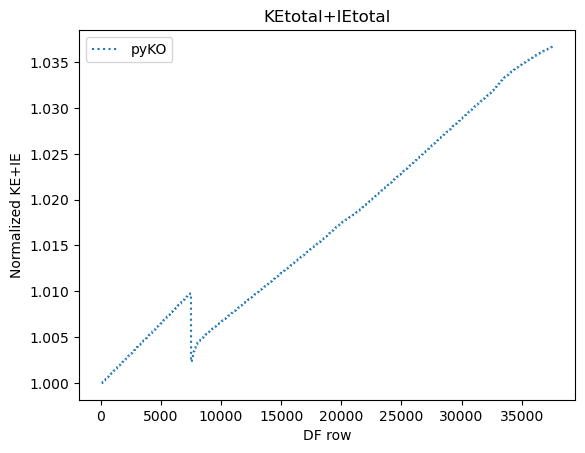

In [13]:
istart = np.where(pko['time']>0.)[0]
plt.plot(pko["etot"][istart]/pko["etot"][istart[0]],':',label='pyKO')
plt.xlabel('DF row')
plt.title('KEtotal+IEtotal')
plt.ylabel('Normalized KE+IE')
plt.legend()


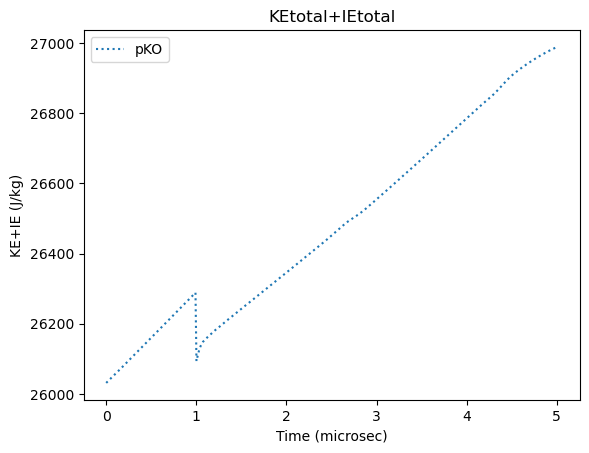

In [14]:
#plt.plot(fko['time'],fko['etot'],label='fKO')
plt.plot(pko['time'],pko['etot'],':',label='pKO')
plt.xlabel('Time (microsec)')
plt.title('KEtotal+IEtotal')
#plt.ylabel('KE+IE (eu/cm3)')
plt.ylabel('KE+IE (J/kg)')
plt.legend()


End of notebook